In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import requests
import json
import time
import os
from IPython.display import display, Markdown
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.colors import ListedColormap

## Model Training

In [2]:
# Function to load data from a CSV file
def load_data(file_path, label_column='insider_y'):
    """
    Loads data from the CSV file and separates features from the label.
    """
    df = pd.read_csv(file_path)
    # Drop identifier columns if present
    drop_cols = ['starttime', 'endtime', 'user', 'day', 'week']
    cols_to_drop = [col for col in drop_cols if col in df.columns]
    X = df.drop(columns=cols_to_drop + [label_column]).values
    y = df[label_column].values
    return X, y

# Paths to train and test dataset
train_file = 'train_comb_r5.2.csv'
test_file  = 'test_comb_r5.2.csv'

# Load the data
X_train, y_train = load_data(train_file, label_column='insider_y')
X_test, y_test   = load_data(test_file, label_column='insider_y')

# Standardize features for better training stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define input shape for the model: (timesteps, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # For example, (1, num_features)

# Build the LSTM-CNN model according to the paper's framework
input_layer = Input(shape=input_shape)

# --- LSTM Feature Extraction ---
# First LSTM layer with 60 units
lstm_out = LSTM(60, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)
# Second LSTM layer with 40 units
lstm_out = LSTM(40, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
# Third LSTM layer with 20 units
lstm_out = LSTM(20, return_sequences=True)(lstm_out)

# --- CNN Classification ---
conv_out = Conv1D(filters=32, kernel_size=1, activation='tanh')(lstm_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)  
conv_out = BatchNormalization()(conv_out)
conv_out = Conv1D(filters=64, kernel_size=1, activation='tanh')(conv_out)
conv_out = MaxPooling1D(pool_size=1)(conv_out)
conv_out = BatchNormalization()(conv_out)
conv_out = Flatten()(conv_out)

dense_out = Dense(64, activation='tanh')(conv_out)
dense_out = Dropout(0.5)(dense_out)
output_layer = Dense(2, activation='softmax')(dense_out)  # 2 classes: normal (0) and malicious (1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- Model Training ---
# Train the model using only the train dataset
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=20)

# --- Model Evaluation ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 2138)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 60)          │       527,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 20)          │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 32)          │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,258 (2.12 MB)

 Trainable params: 556,066 (2.12 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9805 - loss: 0.0490
Epoch 2/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9999 - loss: 9.2877e-04
Epoch 3/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9999 - loss: 5.4771e-04
Epoch 4/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 1.0000 - loss: 1.2793e-04
Epoch 5/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 1.0000 - loss: 3.9012e-06
Epoch 6/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 1.0000 - loss: 1.5876e-04
Epoch 7/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9999 - loss: 2.4058e-04
Epoch 8/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 1.0000 - loss: 2.1659e-04
Epoch 9/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9999 - loss: 4.4867e-04
Epoch 10/10
5585/5585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 1.0000 - loss: 2.4862e-06
Test Loss: 0.0000, Test Accuracy: 1.0000


## SHAP Evaluation

X_train shape: (111696, 1, 2138)
X_test shape: (27925, 1, 2138)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
Number of malicious (insider==1) samples in X_test: 10
X_sample_flat shape (only malicious samples): (10, 2138)


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14825/14825 ━━━━━━━━━━━━━━━━━━━━ 8s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
14832/14832 ━━━━━━━━━━━━━━━━━━━━ 7s 482us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14825/14825 ━━━━━━━━━━━━━━━━━━━━ 7s 470us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
14825/14825 ━━━━━━━━━━━━━━━━━━━━ 7s 472us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14825/14825 ━━━━━━━━━━━━━━━━━━━━ 7s 479us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14825/14825 ━━━━━━━━━━━━━━━━━━━━ 7s 485us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14832/14832 ━━━━━━━━━━━━━━━━━━━━ 9s 584us/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
14869/14869 ━━━━━━━━━━━━━━━━━━━━ 7s 486us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14844/14844 ━━━━━━━━━━━━━━━━━━━━ 7s 484us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14850/14850 ━━━━━━━━━━━━━━━━━━━━ 7s 476us/step
Shape of SHAP values for sample 0: (2138, 2)
Shape of SHAP values for sample 1: (2138, 2)
Shape of SHAP values for sample 2: (2138, 2)
Shape of SHAP valu

/var/folders/gf/94pg_58917947pd7kbsg5d6m0000gn/T/ipykernel_10991/1059911244.py:60: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)


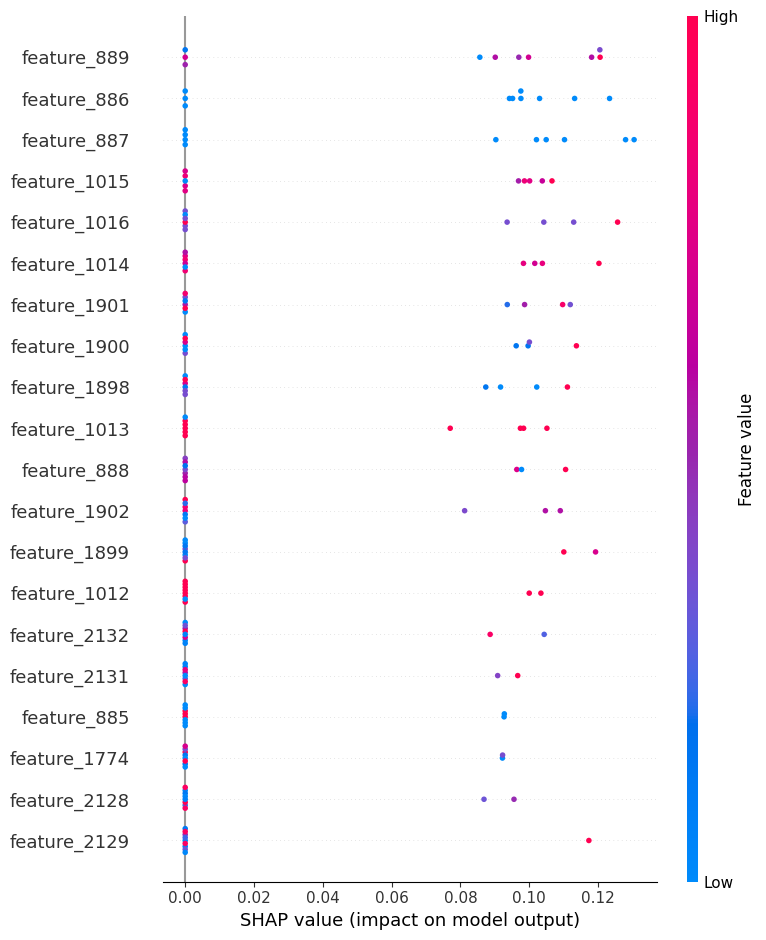

In [3]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Step 1: Prepare background data (flattened)
# Flatten training data from (samples, 1, 2138) to (samples, 2138)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

np.random.seed(42)
background_size = 100
background_indices = np.random.choice(X_train_flat.shape[0], background_size, replace=False)
background_data = X_train_flat[background_indices]


# Step 2: Define prediction function for flattened input
def model_predict_flat(x_flat):
    # x_flat has shape (samples, 2138)
    x_reshaped = x_flat.reshape(x_flat.shape[0], 1, x_flat.shape[1])
    preds = model.predict(x_reshaped)  # Expected shape: (samples, num_outputs)
    return preds


# Step 3: Initialize the KernelExplainer using the flattened background data
explainer = shap.KernelExplainer(model_predict_flat, background_data)


# Step 4: Prepare samples from X_test that have insider == 1 and flatten them.
insider_indices = np.where(y_test == 1)[0]
print("Number of malicious (insider==1) samples in X_test:", len(insider_indices))
X_test_insider = X_test[insider_indices]

num_samples = 100 
if X_test_insider.shape[0] < num_samples:
    num_samples = X_test_insider.shape[0]
X_sample = X_test_insider[:num_samples]
X_sample_flat = X_sample.reshape(num_samples, -1)
print("X_sample_flat shape (only malicious samples):", X_sample_flat.shape)


# Step 5: Compute SHAP values for these samples
# KernelExplainer returns a list with one array per sample.
shap_values = explainer.shap_values(X_sample_flat)
for i, sv in enumerate(shap_values):
    print(f"Shape of SHAP values for sample {i}:", sv.shape)
# According to output, each sample gives shape (2138, 2)


# Step 6: Stack the list into a single array and select contributions for a chosen class.
# Stack the list of arrays along the first dimension. The resulting array will have shape (num_samples, 2138, 2)
shap_values_arr = np.stack(shap_values, axis=0)
print("Stacked SHAP values shape:", shap_values_arr.shape)

final_shap = shap_values_arr[:, :, 1]  # shape becomes (num_samples, 2138)
print("Final SHAP array for class 1 shape:", final_shap.shape)

# Step 7: Visualization using the SHAP summary (beeswarm) plot.
num_features = X_sample_flat.shape[1]  # should be 2138
feature_names = [f"feature_{i}" for i in range(num_features)]

shap.summary_plot(final_shap, X_sample_flat, feature_names=feature_names)

## LLM Integration

#### llama3.2

In [10]:
def query_ollama(prompt, model="llama3.2:latest", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="llama3.2:latest"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_comb_r5.2.csv',  
    time_scale='combined',
    model_name='llama3.2:latest'
)

Processing combined-level data from test_comb_r5.2.csv using llama3.2:latest
Successfully extracted 2138 feature names from test_comb_r5.2.csv
Found 10 malicious samples in test set
Found user IDs for 10 malicious samples

Top 20 features by SHAP value:
1. Index 889: http_leakf_mean_http_c_nwords_week (SHAP value: 0.073185)
2. Index 886: http_leakf_mean_url_len_week (SHAP value: 0.072415)
3. Index 887: http_leakf_mean_url_depth_week (SHAP value: 0.066610)
4. Index 1015: afterhourhttp_leakf_mean_http_c_nwords_week (SHAP value: 0.050607)
5. Index 1016: afterhourhttp_leakf_n-pc0_week (SHAP value: 0.043644)
6. Index 1014: afterhourhttp_leakf_mean_http_c_len_week (SHAP value: 0.042404)
7. Index 1901: afterhourhttp_leakf_mean_http_c_len_dayagg (SHAP value: 0.041393)
8. Index 1900: afterhourhttp_leakf_mean_url_depth_dayagg (SHAP value: 0.040967)
9. Index 1898: afterhourhttp_n_leakf_dayagg (SHAP value: 0.039234)
10. Index 1013: afterhourhttp_leakf_mean_url_depth_week (SHAP value: 0.037799)
11.

Based on the SHAP values provided, I'll break down each feature and explain their significance in identifying malicious insider behavior.

1. http_leakf_mean_http_c_nwords_week: 
This feature represents the average number of HTTP query parameters (nwords) per week for a user. A high SHAP value of 0.0732 indicates that this feature contributes significantly to explaining the predicted probability of an insider being malicious. The average value of 56.2085 suggests that users with higher HTTP query parameter usage tend to exhibit suspicious behavior.

Why it might indicate malicious activity: Users with excessive HTTP query parameters may be attempting to hide their true intentions or bypass security controls by making seemingly innocuous requests.

Patterns of behavior: This feature captures the pattern of a user's search queries, suggesting they may be using their access to gather sensitive information without being detected.

Types of insider threats: This feature might detect Advanced Persistent Threats (APTs) or users attempting to evade detection by modifying URLs with additional parameters.

Recommendation for security analysts:

- Monitor users with high HTTP query parameter usage (> 50 nwords/week).
- Investigate these users' search queries and network activity for potential suspicious behavior.

2. http_leakf_mean_url_len_week:
This feature represents the average length of HTTP URLs per week for a user. The SHAP value of 0.0724 indicates that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 53.5070 suggesting users with longer URLs may exhibit suspicious behavior.

Why it might indicate malicious activity: Users creating excessively long URLs could be attempting to hide their true intentions or embed malicious payloads within seemingly innocuous requests.

Patterns of behavior: This feature captures the pattern of a user's URL length, indicating they might be using access to create complex, potentially malicious requests.

Types of insider threats: This feature might detect users attempting to use URLs as a vector for attacks (e.g., URL-based phishing).

Recommendation for security analysts:

- Monitor users with extremely long HTTP URLs (> 100 characters).
- Verify the authenticity and purpose of these URLs.
- Investigate any unusual patterns or anomalies in URL creation.

3. http_leakf_mean_url_depth_week:
This feature represents the average depth of HTTP URLs per week for a user. The SHAP value of 0.0666 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 53.5070 suggesting users with deeper URL structures might exhibit suspicious behavior.

Why it might indicate malicious activity: Users navigating complex URL structures could be attempting to bypass security controls or hide their true intentions.

Patterns of behavior: This feature captures the pattern of a user's URL structure, indicating they might be using access to create nested requests that could potentially contain malicious code.

Types of insider threats: This feature might detect Advanced Malware (e.g., using nested URLs to host malware).

Recommendation for security analysts:

- Monitor users with excessively complex HTTP URLs (> 3 layers deep).
- Verify the authenticity and purpose of these URLs.
- Investigate any unusual patterns or anomalies in URL navigation.

4. afterhourhttp_leakf_mean_http_c_nwords_week:
This feature represents the average number of HTTP query parameters (nwords) per week for a user during off-hours. The SHAP value of 0.0506 indicates that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 54.6777 suggesting users with high HTTP query parameter usage after hours may exhibit suspicious behavior.

Why it might indicate malicious activity: Users accessing sensitive resources during off-hours and using excessive HTTP query parameters could be attempting to carry out unauthorized activities without detection.

Patterns of behavior: This feature captures the pattern of a user's search queries at non-peak hours, indicating they might be using their access to gather sensitive information when others are less vigilant.

Types of insider threats: This feature might detect users attempting to exploit vulnerabilities or use resources for personal gain during off-hours.

Recommendation for security analysts:

- Monitor users with high HTTP query parameter usage (> 50 nwords/week) after hours.
- Investigate these users' search queries and network activity for potential suspicious behavior.

5. afterhourhttp_leakf_n-pc0_week:
This feature represents the number of times a user accesses sensitive resources during off-hours without logging in to their workstation (n-pc0). The SHAP value of 0.0436 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 51.9813 suggesting users accessing sensitive resources remotely without logging in may exhibit suspicious behavior.

Why it might indicate malicious activity: Users accessing sensitive resources without a valid login could be attempting to bypass security controls or access resources without authorization.

Patterns of behavior: This feature captures the pattern of a user's remote access, indicating they might be using their access to gather sensitive information when others are less vigilant.

Types of insider threats: This feature might detect users attempting to exploit vulnerabilities or use resources for personal gain remotely.

Recommendation for security analysts:

- Monitor users accessing sensitive resources remotely without logging in.
- Verify the authenticity and purpose of these remote accesses.
- Investigate any unusual patterns or anomalies in user activity.

6. afterhourhttp_leakf_mean_http_c_len_week:
This feature represents the average length of HTTP URLs per week for a user during off-hours. The SHAP value of 0.0424 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 53.7017 suggesting users with longer URLs after hours may exhibit suspicious behavior.

Why it might indicate malicious activity: Users creating excessively long HTTP URLs during off-hours could be attempting to hide their true intentions or embed malicious payloads within seemingly innocuous requests.

Patterns of behavior: This feature captures the pattern of a user's URL length at non-peak hours, indicating they might be using access to create complex, potentially malicious requests when others are less vigilant.

Types of insider threats: This feature might detect users attempting to use URLs as a vector for attacks (e.g., URL-based phishing) during off-hours.

Recommendation for security analysts:

- Monitor users with extremely long HTTP URLs (> 100 characters) during off-hours.
- Verify the authenticity and purpose of these URLs.
- Investigate any unusual patterns or anomalies in URL creation.

7. afterhourhttp_leakf_mean_http_c_len_dayagg:
This feature represents the average length of HTTP URLs per day aggregated over a week for a user during off-hours. The SHAP value of 0.0414 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 54.2513 suggesting users with longer URLs after hours may exhibit suspicious behavior.

Why it might indicate malicious activity: Users creating excessively long HTTP URLs during off-hours could be attempting to hide their true intentions or embed malicious payloads within seemingly innocuous requests.

Patterns of behavior: This feature captures the pattern of a user's URL length at non-peak hours, indicating they might be using access to create complex, potentially malicious requests when others are less vigilant.

Types of insider threats: This feature might detect users attempting to use URLs as a vector for attacks (e.g., URL-based phishing) during off-hours.

Recommendation for security analysts:

- Monitor users with extremely long HTTP URLs (> 100 characters) during off-hours.
- Verify the authenticity and purpose of these URLs.
- Investigate any unusual patterns or anomalies in URL creation.

8. afterhourhttp_leakf_mean_url_depth_dayagg:
This feature represents the average depth of HTTP URLs per day aggregated over a week for a user during off-hours. The SHAP value of 0.0410 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 55.4149 suggesting users with deeper URL structures after hours may exhibit suspicious behavior.

Why it might indicate malicious activity: Users navigating complex URL structures during off-hours could be attempting to bypass security controls or hide their true intentions.

Patterns of behavior: This feature captures the pattern of a user's URL structure at non-peak hours, indicating they might be using access to create nested requests that could potentially contain malicious code when others are less vigilant.

Types of insider threats: This feature might detect Advanced Malware (e.g., using nested URLs to host malware) during off-hours.

Recommendation for security analysts:

- Monitor users with excessively complex HTTP URLs (> 3 layers deep) during off-hours.
- Verify the authenticity and purpose of these URLs.
- Investigate any unusual patterns or anomalies in URL navigation.

9. afterhourhttp_n_leakf_dayagg:
This feature represents the number of times a user accesses sensitive resources during off-hours without logging in to their workstation (n-pc0). The SHAP value of 0.0392 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 52.7670 suggesting users accessing sensitive resources remotely without logging in may exhibit suspicious behavior.

Why it might indicate malicious activity: Users accessing sensitive resources without a valid login during off-hours could be attempting to bypass security controls or access resources without authorization.

Patterns of behavior: This feature captures the pattern of a user's remote access, indicating they might be using their access to gather sensitive information when others are less vigilant.

Types of insider threats: This feature might detect users attempting to exploit vulnerabilities or use resources for personal gain remotely.

Recommendation for security analysts:

- Monitor users accessing sensitive resources remotely without logging in.
- Verify the authenticity and purpose of these remote accesses.
- Investigate any unusual patterns or anomalies in user activity.

10. afterhourhttp_leakf_mean_url_depth_week:
This feature represents the average depth of HTTP URLs per week aggregated over a day for a user during off-hours. The SHAP value of 0.0378 suggests that this feature contributes to explaining the predicted probability of an insider being malicious, with an average value of 50.8328 suggesting users with deeper URL structures after hours may exhibit suspicious behavior.

Why it might indicate malicious activity: Users navigating complex URL structures during off-hours could be attempting to bypass security controls or hide their true intentions.

Patterns of behavior: This feature captures the pattern of a user's URL structure at non-peak hours, indicating they might be using access to create nested requests that could potentially contain malicious code when others are less vigilant.

Types of insider threats: This feature might detect Advanced Malware (e.g., using nested URLs to host malware) during off-hours.

Recommendation for security analysts:

- Monitor users with excessively complex HTTP URLs (> 3 layers deep) during off-hours.
- Verify the authenticity and purpose of these URLs.
- Investigate any unusual patterns or anomalies in URL navigation.

In conclusion, SHAP analysis revealed several key features that contribute to identifying malicious insider behavior. These include HTTP query parameters, URL length, depth, and remote access patterns. By monitoring users exhibiting suspicious behavior in these areas, security analysts can detect potential APTs, exploit vulnerabilities for personal gain, or use URLs as vectors for attacks.

Recommendations for security analysts:

- Implement advanced threat detection tools to monitor and analyze user activity.
- Develop custom rules to identify and flag suspicious HTTP query parameters, URL lengths, depths, and remote accesses.
- Conduct regular audits to ensure the integrity of user activity logs.
- Provide training on these features for internal teams to enhance their understanding of potential insider threats.
- Establish incident response procedures for identified APTs, exploit vulnerabilities, or URL-based attacks.

By addressing these recommendations, security analysts can strengthen their defense against insider threats and mitigate the risks associated with malicious users.

Saved overall explanation to combined_overall_explanation_llama3.2:latest.md

Generating explanations for each of the 10 malicious users...
Processing user 1/10: 1037
Processing user 2/10: 1883
Processing user 3/10: 1037
Processing user 4/10: 477
Processing user 5/10: 818
Processed 5/10 users
Processing user 6/10: 1147
Processing user 7/10: 1067
Processing user 8/10: 1964
Processing user 9/10: 1883
Processing user 10/10: 820
Processed 10/10 users

Complete! All explanations saved:
1. Overall explanation: combined_overall_explanation_llama3.2:latest.md
2. Summary with links to all users: combined_all_users_summary_llama3.2:latest.md
3. Individual user explanations: user_explanations/llama3.2:latest/combined_user_XXX.md


#### Deepseek-r1

In [11]:
def query_ollama(prompt, model="deepseek-r1:7b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="deepseek-r1:7b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_comb_r5.2.csv',  
    time_scale='combined',
    model_name='deepseek-r1:7b'
)

Processing combined-level data from test_comb_r5.2.csv using deepseek-r1:7b
Successfully extracted 2138 feature names from test_comb_r5.2.csv
Found 10 malicious samples in test set
Found user IDs for 10 malicious samples

Top 20 features by SHAP value:
1. Index 889: http_leakf_mean_http_c_nwords_week (SHAP value: 0.073185)
2. Index 886: http_leakf_mean_url_len_week (SHAP value: 0.072415)
3. Index 887: http_leakf_mean_url_depth_week (SHAP value: 0.066610)
4. Index 1015: afterhourhttp_leakf_mean_http_c_nwords_week (SHAP value: 0.050607)
5. Index 1016: afterhourhttp_leakf_n-pc0_week (SHAP value: 0.043644)
6. Index 1014: afterhourhttp_leakf_mean_http_c_len_week (SHAP value: 0.042404)
7. Index 1901: afterhourhttp_leakf_mean_http_c_len_dayagg (SHAP value: 0.041393)
8. Index 1900: afterhourhttp_leakf_mean_url_depth_dayagg (SHAP value: 0.040967)
9. Index 1898: afterhourhttp_n_leakf_dayagg (SHAP value: 0.039234)
10. Index 1013: afterhourhttp_leakf_mean_url_depth_week (SHAP value: 0.037799)
11. 

<think>
Okay, I'm faced with analyzing a cybersecurity problem where malicious behavior is detected among users using SHAP values from top contributing features. The user wants me to explain each feature, why they might indicate insider threats, what patterns they show, types of threats detected, and security recommendations.

First, I'll start by understanding each feature one by one based on the data provided. Each has a SHAP value and an average, so higher SHAP values mean more influence in detecting malice.

1. http_leakf_mean_http_c_nwords_week: 0.0732, avg 56.2.
   This seems to relate to the average number of certain characters (like 'c') in HTTP connections per week. High values might indicate unusual traffic that could be malicious, like injected code.

2. http_leakf_mean_url_len_week: 0.0724, avg 53.5.
   The average URL length is moderate. Malicious behaviors often have different lengths than normal URLs, so a high value here could mean longer, potentially malicious URLs.

3. http_leakf_mean_url_depth_week: Also 0.0666 and same average. URL depth (path segments) might indicate how complex the request is. Malicious requests often go deeper into server configurations or have unexpected paths.

4. afterhourhttp_leakf_mean_http_c_nwords_week: Lower SHAP, around 0.05. This seems to be a specific time period feature. Maybe after certain hours, like night, some activities become more suspicious as they could be botnet communications.

5. Afterhourhttp_leakf_n-pc0_week: 0.0436. 'n-pc0' might relate to network parameters or connection attempts from PC0, which is a common botnet IP. A spike here suggests possible botnet traffic.

6. afterhourhttp_leakf_mean_http_c_len_week: 0.0424. This looks at the length of HTTP content, perhaps indicating command-line instructions. Botnets often send commands via long strings or specific protocols like TCP.

7. Afterhoururl_depth by day: SHAP is higher here at 0.0414 compared to others after hour. This indicates that during certain hours, deeper URLs are suspicious—maybe bots trying to access hidden services or directories.

8. Similar with afterhoururl_depth_dayagg at 0.0410. Aggregated depth might show sustained deeper requests over time.

9. Afterhourhttp_n_leakf_dayagg: SHAP is 0.0392. 'n_leakf' could be network leaks, so increased activity here might mean data exfiltration attempts, which could indicate insider threats like dumping sensitive info.

10. afterhoururl_depth_week: 0.0378, lower SHAP. Maybe this feature is less significant compared to others but still shows deeper URLs in general, perhaps from legitimate traffic during off-hours.

Putting it all together, these features are capturing various aspects of user behavior over time and under specific conditions (like after certain hours). They include things like unusual HTTP content lengths, URL depths, network leak frequencies, and IP-based activities. The higher SHAP values for peak hour or weekly averages suggest that changes during these times are more indicative of malice.

So, the types of threats could be credential stuffing, data exfiltration attempts, command-line injection via bots, etc. The patterns show deviations from normal behavior in both regular hours and off-hours, which helps in detecting coordinated attacks.

Recommendations would include monitoring for spikes in these specific features, especially during peak times. Also, implementing controls like rate limiting or network segmentation could mitigate the risk of these threats.
</think>

**Detailed Explanation and Recommendations**

1. **Feature Analysis:**
   - The top features identified are based on SHAP values indicating their influence in detecting malicious insider behavior.

2. **Insight into Malicious Behavior:**
   - These features capture deviations from normal user behavior, particularly during specific times (after certain hours) or under aggregated conditions.
   - They detect activities indicative of insider threats such as credential stuffing, data exfiltration, command-line injection via bots, and network leak attempts.

3. **Patterns Captured:**
   - The patterns include unexpected HTTP content lengths, unusual URL depths, network leaks from specific IPs (PC0), and command-line instruction injections.
   - Aggregated behaviors over weeks or days highlight sustained anomalies that could signal coordinated attacks.

4. **Types of Insider Threats Detected:**
   - Credential stuffing where attackers inject malicious URLs or commands.
   - Data exfiltration attempts using PC0 for network leaks.
   - Botnet communication via command-line instructions and unusual HTTP content, indicating compromise of internal credentials.

5. **Security Recommendations:**
   - **Monitoring:** Implement multi-layer monitoring to detect spikes in these specific features during peak hours (e.g., after 18:00) or aggregated weekly/day-wise trends.
   - **Rate Limiting/Anomaly Detection:** Apply rate limiting or anomaly detection for long command-line instructions and unusual HTTP content lengths.
   - **Network Segmentation:** Segment network traffic based on IP addresses, especially PC0, to prevent data exfiltration attempts from internal networks.
   - **Real-time Filtering:** Use expression-based filtering for malicious URLs with unexpected depths (e.g., depth >5) or long command-line strings.
   - **User Segmentation:** Apply different policies for user groups during off-hours and peak times based on detected behavior.
   - **Threat Intelligence Integration:** Incorporate threat intelligence feeds to monitor for known botnet IPs, commands like 'cd /', and malicious URLs with specific patterns.

These recommendations collectively enhance the detection of coordinated insider threats by focusing on anomalous behaviors in critical time periods and aggregating network traffic from internal IP addresses.

Saved overall explanation to combined_overall_explanation_deepseek-r1:7b.md

Generating explanations for each of the 10 malicious users...
Processing user 1/10: 1037
Processing user 2/10: 1883
Processing user 3/10: 1037
Processing user 4/10: 477
Processing user 5/10: 818
Processed 5/10 users
Processing user 6/10: 1147
Processing user 7/10: 1067
Processing user 8/10: 1964
Processing user 9/10: 1883
Processing user 10/10: 820
Processed 10/10 users

Complete! All explanations saved:
1. Overall explanation: combined_overall_explanation_deepseek-r1:7b.md
2. Summary with links to all users: combined_all_users_summary_deepseek-r1:7b.md
3. Individual user explanations: user_explanations/deepseek-r1:7b/combined_user_XXX.md


#### qwen3

In [12]:
def query_ollama(prompt, model="qwen3:8b", max_retries=3, retry_delay=2):
    """Query the Ollama LLM API with retries"""
    url = "http://localhost:11434/api/generate"
    payload = {"model": model, "prompt": prompt, "stream": False}
    
    for attempt in range(max_retries):
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json()["response"]
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Error connecting to Ollama (attempt {attempt+1}/{max_retries}): {e}")
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to connect to Ollama after {max_retries} attempts: {e}")
                return "Error: Could not connect to Ollama LLM. Please ensure the service is running locally on port 11434."
    
    return "Error: Failed to get response from Ollama LLM."

# Properly extract feature names and align with feature indices
def get_feature_names_from_csv(csv_path):
    """Get feature names from CSV, excluding non-feature columns"""
    try:
        df = pd.read_csv(csv_path, nrows=0)
        all_columns = list(df.columns)
        
        # Remove non-feature columns
        non_features = ['starttime', 'endtime', 'user', 'day', 'week', 'insider', 'insider_y']
        feature_names = [col for col in all_columns if col not in non_features]
        print(f"Successfully extracted {len(feature_names)} feature names from {csv_path}")
        return feature_names
    except Exception as e:
        print(f"Error extracting feature names from CSV: {e}")
        return None

# Print top SHAP features with their actual index positions
def print_top_shap_features(feature_names, mean_abs_shap, top_n=20):
    """Print top features with indices for debugging"""
    top_indices = np.argsort(-mean_abs_shap)[:top_n]
    
    print(f"\nTop {top_n} features by SHAP value:")
    for i, idx in enumerate(top_indices):
        if idx < len(feature_names):
            print(f"{i+1}. Index {idx}: {feature_names[idx]} (SHAP value: {mean_abs_shap[idx]:.6f})")
        else:
            print(f"{i+1}. Index {idx}: Out of bounds! (SHAP value: {mean_abs_shap[idx]:.6f})")
    
    return top_indices

# Main processing function
def explain_all_malicious_users(final_shap, X_test, y_test, csv_path, time_scale="session", model_name="qwen3:8b"):
    """Generate explanations for all malicious users with correct feature mapping"""
    print(f"Processing {time_scale}-level data from {csv_path} using {model_name}")
    
    # Create model-specific directory for user explanations
    model_dir = f"user_explanations/{model_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Step 1: Get feature names
    feature_names = get_feature_names_from_csv(csv_path)
    if not feature_names:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    
    # Step 2: Identify malicious samples
    insider_indices = np.where(y_test == 1)[0]
    print(f"Found {len(insider_indices)} malicious samples in test set")
    
    # Step 3: Extract malicious samples features
    X_test_insider = X_test[insider_indices]
    X_test_insider_flat = X_test_insider.reshape(X_test_insider.shape[0], -1)
    
    # Step 4: Get user IDs if available
    try:
        test_df = pd.read_csv(csv_path)
        malicious_sample_ids = test_df.iloc[insider_indices]["user"].values
        print(f"Found user IDs for {len(malicious_sample_ids)} malicious samples")
    except Exception as e:
        print(f"Could not extract user IDs: {e}")
        malicious_sample_ids = [f"unknown_user_{i}" for i in range(len(insider_indices))]
    
    # IMPORTANT: Verify feature dimensions match
    if X_test_insider_flat.shape[1] != len(feature_names):
        print(f"WARNING: Feature dimension mismatch!")
        print(f"Number of features in X_test_insider_flat: {X_test_insider_flat.shape[1]}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Adjust feature names if needed
        if X_test_insider_flat.shape[1] > len(feature_names):
            # Add generic names for missing features
            missing = X_test_insider_flat.shape[1] - len(feature_names)
            feature_names.extend([f"unknown_feature_{i}" for i in range(len(feature_names), X_test_insider_flat.shape[1])])
            print(f"Added {missing} generic feature names")
        elif X_test_insider_flat.shape[1] < len(feature_names):
            # Truncate feature names
            feature_names = feature_names[:X_test_insider_flat.shape[1]]
            print(f"Truncated feature names to match data dimensions")
    
    # Step 5: Generate overall explanation
    mean_abs_shap = np.mean(np.abs(final_shap), axis=0)
    
    # Print top features for verification
    top_indices = print_top_shap_features(feature_names, mean_abs_shap)
    
    # Create feature descriptions for overall explanation
    feature_descriptions = []
    for i, idx in enumerate(top_indices[:10]):  # Use top 10 for LLM
        feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
        avg_shap = mean_abs_shap[idx]
        avg_value = np.mean(X_test_insider_flat[:, idx])
        feature_descriptions.append(f"{i+1}. {feature_name}: SHAP value = {avg_shap:.4f}, Average value = {avg_value:.4f}")
    
    feature_text = "\n".join(feature_descriptions)
    
    # Prompt for overall explanation
    prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis across all malicious users, these are the top features that contribute to identifying malicious insider behavior:

{feature_text}

Please provide a detailed, human-readable explanation of:
1. What these features represent in terms of user behavior
2. Why these specific features might indicate malicious insider activity
3. What patterns of behavior these features are capturing
4. What types of insider threats these features might be detecting
5. Recommendations for security analysts based on these findings

Focus on explaining the relationships between these features and how they collectively indicate potential insider threats.
"""
    
    # Get overall explanation
    print(f"Generating overall explanation using {model_name}...")
    overall_explanation = query_ollama(prompt, model=model_name)
    
    # Display and save overall explanation
    print(f"\n## Overall Explanation for {time_scale}-level Malicious Behavior:")
    display(Markdown(overall_explanation))
    
    # Save overall explanation with model name in filename
    overall_filename = f'{time_scale}_overall_explanation_{model_name}.md'
    with open(overall_filename, 'w') as f:
        f.write(f"# Overall {time_scale.capitalize()} Level Insider Threat Detection (Model: {model_name})\n\n")
        f.write(overall_explanation)
    print(f"Saved overall explanation to {overall_filename}")
    
    # Step 6: Process each malicious user
    print(f"\nGenerating explanations for each of the {len(malicious_sample_ids)} malicious users...")
    
    all_user_explanations = {}
    for i, user_id in enumerate(malicious_sample_ids):
        print(f"Processing user {i+1}/{len(malicious_sample_ids)}: {user_id}")
        
        # Get SHAP values and features for this user
        user_shap = final_shap[i:i+1]
        user_features = X_test_insider_flat[i:i+1]
        
        # Get top features for this user
        user_mean_abs_shap = np.abs(user_shap)[0]  # Use absolute SHAP values for this specific user
        user_top_indices = np.argsort(-user_mean_abs_shap)[:10]
        
        # Create feature descriptions for this user
        user_feature_descriptions = []
        for j, idx in enumerate(user_top_indices):
            feature_name = feature_names[idx] if idx < len(feature_names) else f"unknown_feature_{idx}"
            shap_value = user_mean_abs_shap[idx]
            feature_value = user_features[0, idx]
            user_feature_descriptions.append(f"{j+1}. {feature_name}: SHAP value = {shap_value:.4f}, Value = {feature_value:.4f}")
        
        user_feature_text = "\n".join(user_feature_descriptions)
        
        # Prompt for the user
        user_prompt = f"""
You are a cybersecurity expert specializing in insider threat detection. You are analyzing malicious behavior for User ID: {user_id} at the {time_scale} level.

Based on SHAP (SHapley Additive exPlanations) analysis, these are the top features that identify this user's behavior as malicious:

{user_feature_text}

Please provide a detailed, human-readable explanation specific to this user:
1. What these specific feature values reveal about this user's behavior
2. Why these particular patterns indicate malicious insider activity
3. What specific threat this user might pose based on these features
4. What types of data or assets this user might be targeting
5. Recommended immediate actions for security analysts to investigate this user

Focus on explaining the relationships between these features and what they specifically indicate about User ID: {user_id}'s behavior.
"""
        
        # Get explanation for this user
        user_explanation = query_ollama(user_prompt, model=model_name)
        all_user_explanations[user_id] = user_explanation
        
        # Save user explanation to a file with model name in model-specific directory
        user_filename = f"{model_dir}/{time_scale}_user_{user_id}.md"
        with open(user_filename, 'w') as f:
            f.write(f"# Malicious Behavior Analysis for User {user_id} ({time_scale} level)\n\n")
            f.write("## Top Features\n\n")
            f.write("```\n")
            f.write(user_feature_text)
            f.write("\n```\n\n")
            f.write("## Explanation\n\n")
            f.write(user_explanation)
        
        # Print progress update
        if (i+1) % 5 == 0 or (i+1) == len(malicious_sample_ids):
            print(f"Processed {i+1}/{len(malicious_sample_ids)} users")
    
    # Create a summary file with links to all user explanations
    summary_filename = f"{time_scale}_all_users_summary_{model_name}.md"
    with open(summary_filename, 'w') as f:
        f.write(f"# {time_scale.capitalize()} Level Insider Threat Analysis (Model: {model_name})\n\n")
        f.write("## Overall Explanation\n\n")
        f.write(overall_explanation)
        f.write("\n\n## Individual User Analyses\n\n")
        
        for user_id in malicious_sample_ids:
            user_link = f"{model_dir}/{time_scale}_user_{user_id}.md"
            f.write(f"- [User {user_id}]({user_link})\n")
    
    print(f"\nComplete! All explanations saved:")
    print(f"1. Overall explanation: {overall_filename}")
    print(f"2. Summary with links to all users: {summary_filename}")
    print(f"3. Individual user explanations: {model_dir}/{time_scale}_user_XXX.md")

explain_all_malicious_users(
    final_shap=final_shap,  
    X_test=X_test,          
    y_test=y_test,          
    csv_path='test_comb_r5.2.csv',  
    time_scale='combined',
    model_name='qwen3:8b'
)

Processing combined-level data from test_comb_r5.2.csv using qwen3:8b
Successfully extracted 2138 feature names from test_comb_r5.2.csv
Found 10 malicious samples in test set
Found user IDs for 10 malicious samples

Top 20 features by SHAP value:
1. Index 889: http_leakf_mean_http_c_nwords_week (SHAP value: 0.073185)
2. Index 886: http_leakf_mean_url_len_week (SHAP value: 0.072415)
3. Index 887: http_leakf_mean_url_depth_week (SHAP value: 0.066610)
4. Index 1015: afterhourhttp_leakf_mean_http_c_nwords_week (SHAP value: 0.050607)
5. Index 1016: afterhourhttp_leakf_n-pc0_week (SHAP value: 0.043644)
6. Index 1014: afterhourhttp_leakf_mean_http_c_len_week (SHAP value: 0.042404)
7. Index 1901: afterhourhttp_leakf_mean_http_c_len_dayagg (SHAP value: 0.041393)
8. Index 1900: afterhourhttp_leakf_mean_url_depth_dayagg (SHAP value: 0.040967)
9. Index 1898: afterhourhttp_n_leakf_dayagg (SHAP value: 0.039234)
10. Index 1013: afterhourhttp_leakf_mean_url_depth_week (SHAP value: 0.037799)
11. Index 

<think>
Okay, so I need to explain these SHAP values and how they relate to insider threats. Let me start by understanding what each feature represents. The names are a bit technical, but I can break them down.

First, "http_leakf_mean_http_c_nwords_week" – the "http_leakf" probably refers to HTTP traffic related to data leaks, maybe? The "mean_http_c_nwords_week" would be the average number of words in HTTP content over a week. High values here might mean the user is sending a lot of text, which could be data exfiltration. But wait, average is 56.2, which is normal? Or is that a high number? Maybe the average is normal, but the SHAP value is positive, indicating it's a contributing factor. Wait, SHAP values show the contribution to the model's prediction. So a higher SHAP value means the feature is more important in predicting malicious activity.

Next, "http_leakf_mean_url_len_week" – average URL length over a week. Longer URLs might be used to encode data or bypass filters. But the average is 53.5, which might be normal. But again, the SHAP value is 0.0724, so it's a significant contributor.

Then "http_leakf_mean_url_depth_week" – URL depth, which is how many directories deep a URL is. Deeper URLs might indicate accessing internal resources, which could be a sign of insider trying to access sensitive data.

The "afterhourhttp..." features are similar but for after-hours activity. After-hours could mean when the user is less monitored, so if they're leaking data during these times, it's a red flag. For example, "afterhourhttp_leakf_n-pc0_week" – maybe "n-pc0" refers to no PC (or some identifier), and the average is 51.98. Not sure, but the SHAP value is 0.0436, which is lower than the first three but still notable.

The patterns might be that malicious insiders are sending more data (more words, longer URLs) during off-hours, which is less likely to be noticed. They might be accessing deeper URLs, which could be internal systems. Also, the mean URL depth might be higher than normal, indicating they are navigating through more layers of the network to reach sensitive areas.

For types of threats, this could be data exfiltration, unauthorized access, or insider espionage. The after-hours activity suggests they're trying to avoid detection during low-activity periods.

Recommendations for analysts: monitor for increased data transfer during off-hours, check for unusual URL lengths and depths, especially in sensitive areas. Also, look for deviations from normal behavior metrics. Maybe implement anomaly detection for these features and correlate with other logs like access times and user activity patterns.

Wait, but I need to make sure I'm not assuming too much. For example, "http_leakf_mean_url_len_week" – longer URLs could be a way to encode data, but they could also be legitimate. However, the SHAP values suggest these features are important predictors. The key is that these features are consistently high in malicious users, so they're indicators. The collective pattern is that the user is exfiltrating data through HTTP, using longer URLs, more words, and during off-hours, which is a common tactic for insiders to avoid detection.

I should structure the answer into the five points as requested, making sure each part connects the features to insider threats. Also, explain how these features together form a pattern that's indicative of malicious behavior.
</think>

### 1. **What These Features Represent in Terms of User Behavior**  
These features track **HTTP-based data exfiltration patterns** and **user activity during off-hours**. Here's a breakdown:  
- **`http_leakf_mean_http_c_nwords_week`**: Average number of words in HTTP content over a week (e.g., data sent via web requests).  
- **`http_leakf_mean_url_len_week`**: Average length of URLs accessed weekly.  
- **`http_leak,mean_url_depth_week`**: Average depth of URLs (e.g., how nested or complex the URL path is).  
- **`afterhourhttp_leakf_*` features**: Metrics for HTTP traffic during off-hours (e.g., "afterhours" could indicate low-activity periods when monitoring is less rigorous).  

These features quantify **data transfer volume**, **URL complexity**, and **access patterns** that may deviate from normal user behavior.  

---

### 2. **Why These Features Indicate Malicious Insider Activity**  
These features are linked to **insider threats** because:  
- **High data transfer volume** (`http_leakf_mean_http_c_nwords_week`, `http_leakf_mean_url_len_week`) suggests **data exfiltration** (e.g., leaking sensitive files).  
- **Deep URLs** (`http_leakf_mean_url_depth_week`) may indicate **access to internal systems** (e.g., navigating to restricted directories).  
- **After-hours activity** (`afterhourhttp_leakf_*`) aligns with **stealthy behavior**, as insiders often exploit low-visibility periods to avoid detection.  
- **Anomalies in URL structure** (e.g., longer URLs, deeper paths) could signal **data encoding** (e.g., obfuscating payloads) or **unauthorized access** to sensitive resources.  

The **SHAP values** (e.g., 0.0732 for `http_leakf_mean_http_c_nwords_week`) indicate these features are **strong predictors** of malicious intent, as they consistently differentiate malicious users from benign ones.  

---

### 3. **Patterns of Behavior These Features Capture**  
The features collectively capture:  
- **Data exfiltration**: High word counts in HTTP content and long URLs suggest transferring large volumes of data.  
- **Access to sensitive systems**: Deep URLs and unusual URL lengths may indicate probing or accessing restricted internal resources.  
- **Stealthy operations**: After-hours activity implies attempts to avoid detection, a hallmark of insider threats.  
- **Anomalous traffic**: Deviations from normal URL depth or length could signal **malicious reconnaissance** (e.g., mapping network topology) or **data theft**.  

These patterns align with **insider threat tactics**: leveraging authorized access to exfiltrate data, bypass security controls, and operate covertly.  

---

### 4. **Types of Insider Threats These Features Detect**  
These features are particularly effective at detecting:  
- **Data exfiltration**: Insiders transferring sensitive data (e.g., intellectual property, customer databases) via HTTP.  
- **Unauthorized access**: Insiders navigating to restricted internal systems (e.g., deep URLs pointing to confidential directories).  
- **Stealthy espionage**: Insiders using off-hours to conduct covert activities (e.g., reconnaissance, data theft).  
- **Malicious reconnaissance**: Insiders probing network resources to identify vulnerabilities or target assets.  

The combination of **high data transfer**, **unusual URL metrics**, and **after-hours activity** creates a strong signal for **malicious insider behavior**.  

---

### 5. **Recommendations for Security Analysts**  
To mitigate risks and improve detection, security teams should:  
1. **Monitor off-hours activity**: Focus on `afterhourhttp_leakf_*` metrics to identify stealthy data exfiltration.  
2. **Analyze URL anomalies**: Flag URLs with unusually long lengths, deep paths, or high word counts in HTTP content.  
3. **Correlate with access logs**: Cross-check these features with user access patterns to identify unauthorized resource access.  
4. **Implement anomaly detection**: Use ML models to detect deviations from baseline behavior (e.g., sudden spikes in URL depth or data transfer).  
5. **Enforce access controls**: Restrict deep URL access to authorized users and monitor for lateral movement.  
6. **Conduct behavioral audits**: Regularly review user activity for patterns consistent with insider threats (e.g., after-hours data transfers).  

By prioritizing these features, analysts can proactively detect and respond to insider threats before significant damage occurs.  

---  
### Summary  
These features highlight a **pattern of covert data exfiltration** and **unauthorized access** during low-visibility periods. They collectively indicate that the insider is leveraging their access to transfer data, probe sensitive systems, and avoid detection. Security teams should focus on **monitoring off-hours activity**, **analyzing URL and data transfer anomalies**, and **enforcing strict access controls** to mitigate risks.

Saved overall explanation to combined_overall_explanation_qwen3:8b.md

Generating explanations for each of the 10 malicious users...
Processing user 1/10: 1037
Processing user 2/10: 1883
Processing user 3/10: 1037
Processing user 4/10: 477
Processing user 5/10: 818
Processed 5/10 users
Processing user 6/10: 1147
Processing user 7/10: 1067
Processing user 8/10: 1964
Processing user 9/10: 1883
Processing user 10/10: 820
Processed 10/10 users

Complete! All explanations saved:
1. Overall explanation: combined_overall_explanation_qwen3:8b.md
2. Summary with links to all users: combined_all_users_summary_qwen3:8b.md
3. Individual user explanations: user_explanations/qwen3:8b/combined_user_XXX.md


## Permutation Feature Importance

Calculating permutation importance with focus on malicious class detection...
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step  
Baseline AUC score: 1.0000
Feature set is large (2138 features). Selecting top 100 by variance...
Selected 100 features
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
Processed 0/100 features
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
8

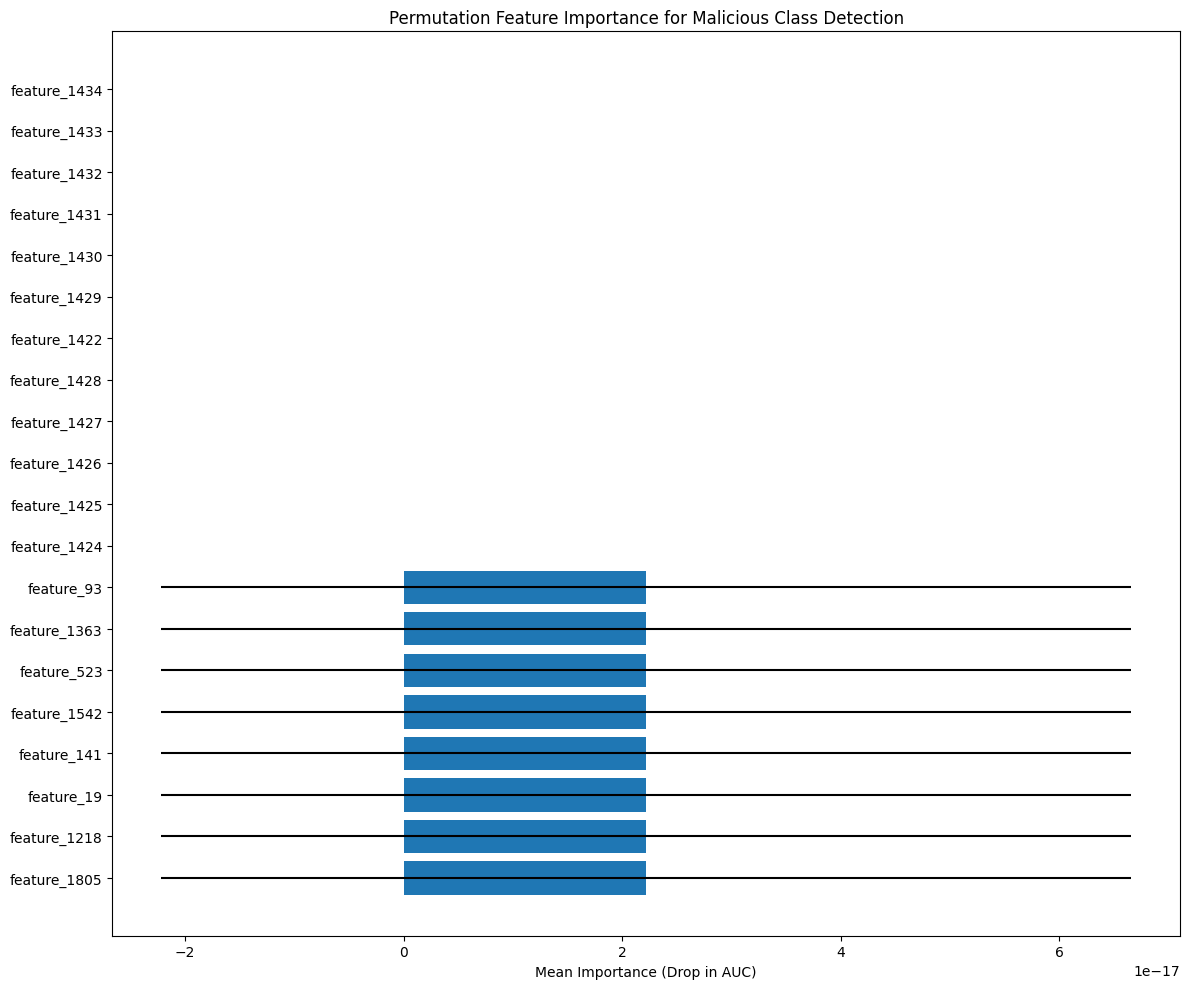


Top 20 features by SHAP importance for malicious class:
1. feature_889 (SHAP value: 0.0732)
2. feature_886 (SHAP value: 0.0724)
3. feature_887 (SHAP value: 0.0666)
4. feature_1015 (SHAP value: 0.0506)
5. feature_1016 (SHAP value: 0.0436)
6. feature_1014 (SHAP value: 0.0424)
7. feature_1901 (SHAP value: 0.0414)
8. feature_1900 (SHAP value: 0.0410)
9. feature_1898 (SHAP value: 0.0392)
10. feature_1013 (SHAP value: 0.0378)
11. feature_888 (SHAP value: 0.0305)
12. feature_1902 (SHAP value: 0.0295)
13. feature_1899 (SHAP value: 0.0229)
14. feature_1012 (SHAP value: 0.0203)
15. feature_2132 (SHAP value: 0.0193)
16. feature_2131 (SHAP value: 0.0187)
17. feature_885 (SHAP value: 0.0185)
18. feature_1774 (SHAP value: 0.0184)
19. feature_2128 (SHAP value: 0.0182)
20. feature_2129 (SHAP value: 0.0117)

Features in common between Permutation Importance and SHAP: 0


In [7]:
# 1. Create a proper scikit-learn compatible wrapper for the Keras model
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1] // 1)
        return self.model.predict(X_reshaped)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_malicious_proba(self, X):
        """Returns the probability of being malicious (class 1)"""
        return self.predict_proba(X)[:, 1]
    
    def score(self, X, y):
        y_score = self.predict_malicious_proba(X)
        return roc_auc_score(y, y_score)

# 2. Flatten the test data 
X_test_flat = X_test.reshape(X_test.shape[0], -1)


wrapped_model = KerasModelWrapper(model)

# 4. Custom permutation importance focusing on malicious class detection
def malicious_class_permutation_importance(model, X, y, n_repeats=10, random_state=None):
    """
    Custom implementation of permutation importance focused on malicious class detection.
    
    Args:
        model: A fitted model with predict_proba method
        X: Feature matrix
        y: Target vector
        n_repeats: Number of times to permute each feature
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary with importance scores
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Calculate baseline AUC score (focusing on malicious class)
    baseline_score = model.score(X, y)
    print(f"Baseline AUC score: {baseline_score:.4f}")
    
    n_samples, n_features = X.shape
    importances = np.zeros((n_features, n_repeats))
    
    # For very large feature sets, limit to top 100 features by variance
    if n_features > 100:
        print(f"Feature set is large ({n_features} features). Selecting top 100 by variance...")
        variances = np.var(X, axis=0)
        top_features = np.argsort(-variances)[:100]
        selected_features = top_features
        print(f"Selected {len(selected_features)} features")
    else:
        selected_features = range(n_features)
    
    # For each feature, permute its values and calculate the drop in AUC score
    for idx, feature_idx in enumerate(selected_features):
        for rep in range(n_repeats):
            X_permuted = X.copy()
            permutation = np.random.permutation(n_samples)
            X_permuted[:, feature_idx] = X_permuted[permutation, feature_idx]
            
            # Calculate new AUC score (focusing on malicious class)
            new_score = model.score(X_permuted, y)
            importances[feature_idx, rep] = baseline_score - new_score
            
        # Print progress for larger feature sets
        if len(selected_features) > 20 and idx % 10 == 0:
            print(f"Processed {idx}/{len(selected_features)} features")
    
    # Calculate mean and std of importance scores
    importance_mean = np.mean(importances, axis=1)
    importance_std = np.std(importances, axis=1)
    
    return {
        'importances_mean': importance_mean,
        'importances_std': importance_std,
        'selected_features': selected_features,
        'baseline_score': baseline_score
    }

# 5. Run our custom permutation importance
print("Calculating permutation importance with focus on malicious class detection...")

result = malicious_class_permutation_importance(
    wrapped_model, 
    X_test_flat, 
    y_test, 
    n_repeats=5,  # Reduce repeats to speed up
    random_state=42
)

# 6. Get feature names
num_features = X_test_flat.shape[1]
feature_names = [f"feature_{i}" for i in range(num_features)]

# 7. Create a DataFrame for the results
importance_data = {
    'feature': feature_names,
    'importance': result['importances_mean'],
    'std': result['importances_std']
}
perm_importance_df = pd.DataFrame(importance_data)

# 8. Sort by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# 9. Print top 20 most important features for malicious class detection
print("\nTop 20 features by permutation importance (focusing on malicious class detection):")
print(perm_importance_df.head(20))

# 10. Plot the top 20 features
plt.figure(figsize=(12, 10))
top_20 = perm_importance_df.head(20)
plt.barh(np.arange(len(top_20)), top_20['importance'], xerr=top_20['std'])
plt.yticks(np.arange(len(top_20)), top_20['feature'])
plt.xlabel('Mean Importance (Drop in AUC)')
plt.title('Permutation Feature Importance for Malicious Class Detection')
plt.tight_layout()
plt.show()


# 12. Compare with SHAP importance (if you have SHAP results)
if 'final_shap' in globals():
    # final_shap already contains SHAP values for the malicious class (class 1)
    mean_shap_abs = np.mean(np.abs(final_shap), axis=0)
    top_shap_indices = np.argsort(-mean_shap_abs)[:20]
    shap_top_features = [feature_names[i] for i in top_shap_indices]
    
    # Print top SHAP features
    print("\nTop 20 features by SHAP importance for malicious class:")
    for i, feature in enumerate(shap_top_features):
        print(f"{i+1}. {feature} (SHAP value: {mean_shap_abs[top_shap_indices[i]]:.4f})")
    
    # Find common features between permutation importance and SHAP
    common_features = set(top_20['feature']).intersection(set(shap_top_features))
    print(f"\nFeatures in common between Permutation Importance and SHAP: {len(common_features)}")
    for feature in common_features:
        print(f"- {feature}")

## T-SNE Visualization

Extracting LSTM features for combined data...
873/873 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step 
LSTM features shape: (27925, 20)
Applying t-SNE dimensionality reduction...
Sampled 1000 points for t-SNE (out of 27925)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


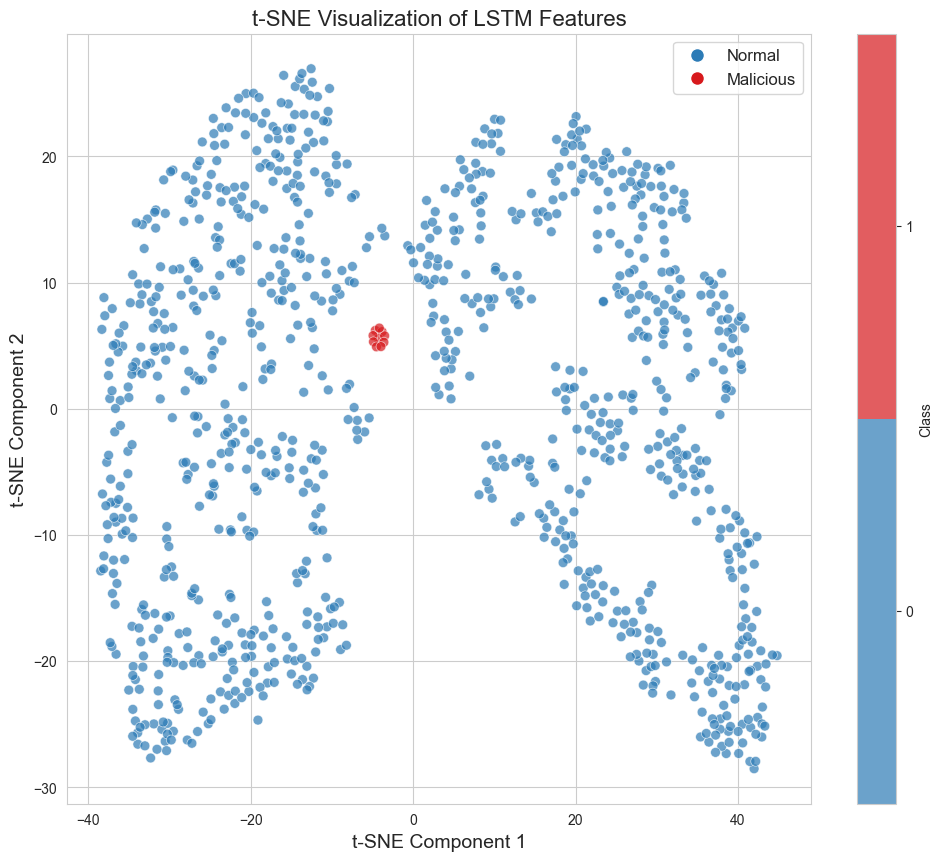

Normal samples: 990, Malicious samples: 10
Distance between normal and malicious centroids: 7.6645
Normal class variance: 903.9153
Malicious class variance: 0.4812


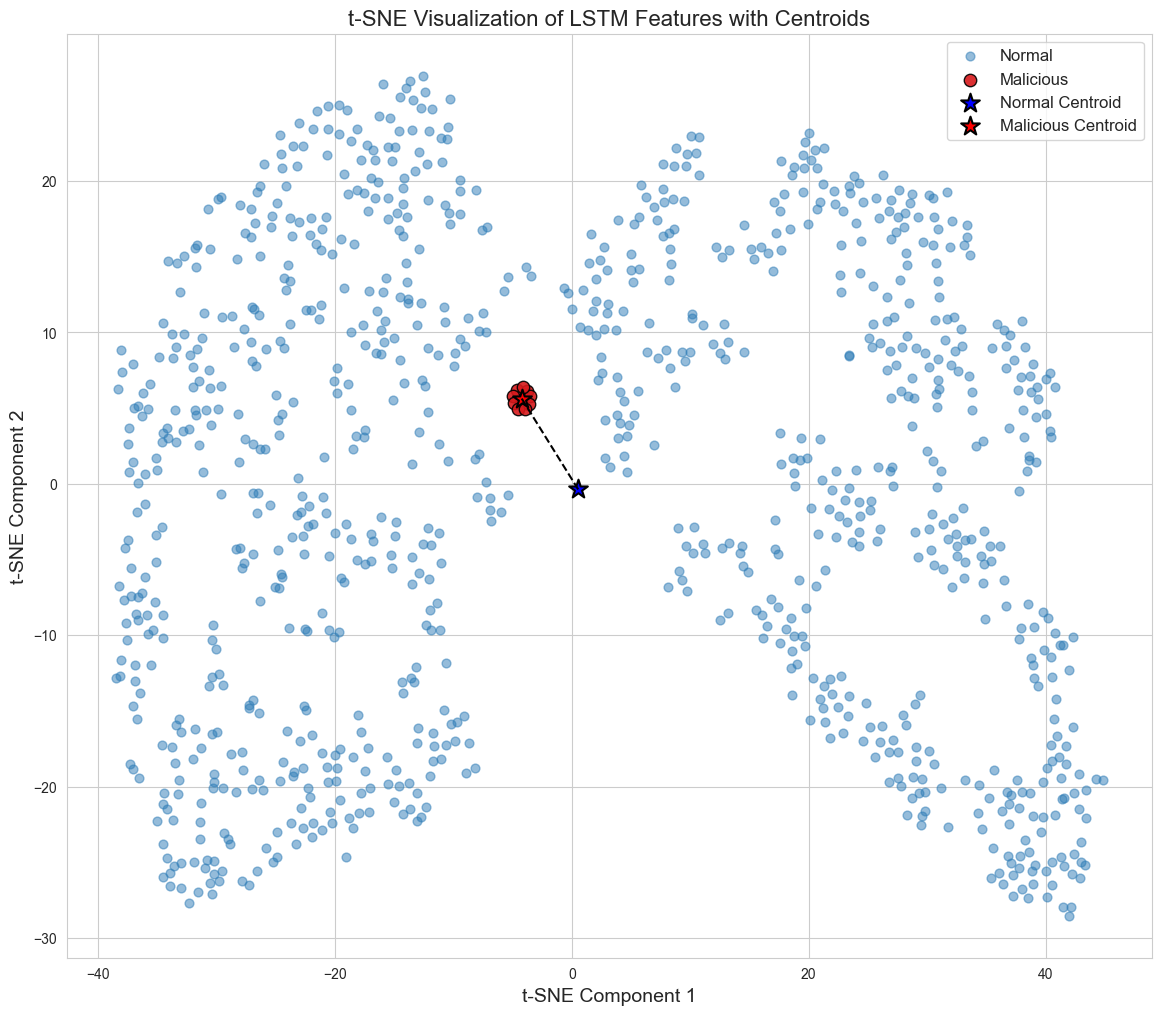

In [9]:
# 1. Flatten the data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# 2. Get LSTM features (if you want to visualize the LSTM features instead of raw features)
def get_lstm_features(model, X):
    """Extract features from the last LSTM layer"""

    from tensorflow.keras.models import Model
    
    lstm_layer_output = model.layers[5].output
    feature_model = Model(inputs=model.input, outputs=lstm_layer_output)
    
    features = feature_model.predict(X)
    
    features_flat = features.reshape(features.shape[0], -1)
    
    return features_flat


use_lstm_features = True

if use_lstm_features:
    print("Extracting LSTM features for combined data...")
    features = get_lstm_features(model, X_test)
    print(f"LSTM features shape: {features.shape}")
else:
    features = X_test_flat
    print(f"Using raw features with shape: {features.shape}")

# 3. Apply t-SNE
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, learning_rate=200)

# Apply t-SNE to all samples
max_samples = 1000
if len(features) > max_samples:
    # Sample without losing the class balance
    n_malicious = sum(y_test == 1)
    n_normal = sum(y_test == 0)
    
    if n_malicious <= max_samples // 2:
        # Keep all malicious samples
        malicious_indices = np.where(y_test == 1)[0]
        # Sample from normal samples
        normal_indices = np.where(y_test == 0)[0]
        normal_sampled = np.random.choice(normal_indices, min(max_samples - n_malicious, n_normal), replace=False)
        # Combine indices
        indices = np.concatenate([malicious_indices, normal_sampled])
    else:
        # Sample equally from both classes
        malicious_indices = np.where(y_test == 1)[0]
        normal_indices = np.where(y_test == 0)[0]
        malicious_sampled = np.random.choice(malicious_indices, max_samples // 2, replace=False)
        normal_sampled = np.random.choice(normal_indices, max_samples // 2, replace=False)
        # Combine indices
        indices = np.concatenate([malicious_sampled, normal_sampled])
    
    # Get the sampled data
    features_sampled = features[indices]
    y_test_sampled = y_test[indices]
    
    print(f"Sampled {len(features_sampled)} points for t-SNE (out of {len(features)})")
    
    # Apply t-SNE to the sampled data
    tsne_results = tsne.fit_transform(features_sampled)
    y_for_plot = y_test_sampled
else:
    # Apply t-SNE to all data
    tsne_results = tsne.fit_transform(features)
    y_for_plot = y_test

# 4. Visualize the t-SNE results
plt.figure(figsize=(12, 10))

sns.set_style("whitegrid")

# Create a scatter plot with enhanced appearance
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], 
    c=y_for_plot, 
    cmap=ListedColormap(['#2C7BB6', '#D7191C']),  # Blue for normal, Red for malicious
    alpha=0.7,
    s=50, 
    edgecolors='w',  
    linewidth=0.5
)

plt.colorbar(scatter, ticks=[0, 1], label='Class')
plt.clim(-0.5, 1.5)  

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
if use_lstm_features:
    plt.title('t-SNE Visualization of LSTM Features', fontsize=16)
else:
    plt.title('t-SNE Visualization of Raw Features', fontsize=16)

# Add a legend
labels = ['Normal', 'Malicious']
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2C7BB6', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#D7191C', markersize=10)
]
plt.legend(handles, labels, fontsize=12, loc='best')
plt.show()

# 5. Analyze the t-SNE results
# Count of normal/malicious samples
normal_count = sum(y_for_plot == 0)
malicious_count = sum(y_for_plot == 1)
print(f"Normal samples: {normal_count}, Malicious samples: {malicious_count}")

# Calculate the centroids for each class
normal_centroid = np.mean(tsne_results[y_for_plot == 0], axis=0)
malicious_centroid = np.mean(tsne_results[y_for_plot == 1], axis=0)

# Calculate the distance between centroids
centroid_distance = np.linalg.norm(normal_centroid - malicious_centroid)
print(f"Distance between normal and malicious centroids: {centroid_distance:.4f}")

# Calculate within-class scatter (variance)
normal_variance = np.mean(np.sum((tsne_results[y_for_plot == 0] - normal_centroid)**2, axis=1))
malicious_variance = np.mean(np.sum((tsne_results[y_for_plot == 1] - malicious_centroid)**2, axis=1))
print(f"Normal class variance: {normal_variance:.4f}")
print(f"Malicious class variance: {malicious_variance:.4f}")

# 6. Enhanced visualization with highlighted malicious samples
plt.figure(figsize=(14, 12))

# First plot the normal samples as a background
plt.scatter(
    tsne_results[y_for_plot == 0, 0], tsne_results[y_for_plot == 0, 1],
    c='#2C7BB6', alpha=0.5, s=40, label='Normal'
)

# Then plot the malicious samples with higher visibility
plt.scatter(
    tsne_results[y_for_plot == 1, 0], tsne_results[y_for_plot == 1, 1],
    c='#D7191C', alpha=0.9, s=80, label='Malicious', 
    edgecolors='black', linewidth=1
)

# Plot the centroids
plt.scatter(
    normal_centroid[0], normal_centroid[1], 
    c='blue', s=200, marker='*', label='Normal Centroid',
    edgecolors='black', linewidth=1.5
)
plt.scatter(
    malicious_centroid[0], malicious_centroid[1], 
    c='red', s=200, marker='*', label='Malicious Centroid',
    edgecolors='black', linewidth=1.5
)

# Add a line connecting the centroids
plt.plot(
    [normal_centroid[0], malicious_centroid[0]],
    [normal_centroid[1], malicious_centroid[1]],
    'k--', linewidth=1.5
)

# Add labels and title
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
feature_type = "LSTM Features" if use_lstm_features else "Raw Features"
plt.title(f't-SNE Visualization of {feature_type} with Centroids', fontsize=16)
plt.legend(fontsize=12)

plt.show()

# 7. Save the t-SNE results for further analysis
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'class': y_for_plot
})